This CNN model was trained on our old dataset that included only 78 images. 

### Install pytorch 

In [11]:
# use cross entropy for classification problems

import time
import platform
import io

import matplotlib.pyplot as plt
from google.colab import files
from matplotlib.pyplot import cm 

# import KFold from scikit-learn
from sklearn.model_selection import KFold

def install_pytorch():
    os = platform.system()
    if os == "Linux":
        !pip3 install http://download.pytorch.org/whl/cu90/torch-0.4.0-cp36-cp36m-linux_x86_64.whl
    elif os == "Windows":
        !pip3 install http://download.pytorch.org/whl/cu90/torch-0.4.0-cp36-cp36m-win_amd64.whl 
    !pip3 install torchvision


# Install PyTorch.
install_pytorch()


import torch
import torch.nn as nn
import torch.optim as optim

### Enable GPU Usage

Models trains much more quickly with GPU. 

In [4]:
# turn on GPU
use_gpu = torch.cuda.is_available()
use_gpu = False
print("GPU Available: {}".format(use_gpu))

GPU Available: False


## Dataset

### Import and read the CSV file 

In [0]:
#import csv dataset
import torchvision
import csv
import os
import pandas as pd 
from urllib import request
import requests

# Upload and read the csv file from the github repo

df = pd.read_csv("https://raw.githubusercontent.com/HelenG123/aeye-alliance/master/Data/data_day3.csv")
df_test = pd.read_csv("https://raw.githubusercontent.com/HelenG123/ai-alliance/master/brailleFinalv2.csv")

#https://raw.githubusercontent.com/HelenG123/ai-alliance/master/braille_data.csv
# # Read the CSV file from a local directory
# dataset_name = list(dataset.keys())[0]
# df = pd.read_csv(io.StringIO(dataset[dataset_name].decode('utf-8')))


### Generate the Targets
Create a dictionary that contains the target number for each image in the Braille alphabet.


In [6]:
# not using one hot encoding vector
# using 1-26 to represent a-z instead

import string

target = {}
alphabet = list(string.ascii_lowercase)

number = 0 
for letter in alphabet: 
  target[letter] = number
  number += 1

print(target)

{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25}


In [0]:
# import string
# alphabet = list(string.ascii_lowercase)

# target = {}

# # Initalize a target dict that has the letters as its keys and as its value
# # an empty one-hot encoding of size 26
# for letter in alphabet: 
#   target[letter] = [0] * 26

# # Do the one-hot encoding for each letter now 
# curr_pos = 0 
# for curr_letter in target.keys():
#   target[curr_letter][curr_pos] = 1
#   curr_pos += 1  

# print(target)

### Iterate over the CSV files to add the targets
Create a dictionary of the images that contains the image as a Tensor and its target as a number between 1-26.

In [28]:
from scipy import misc
from io import BytesIO
import urllib
import cv2
import numpy as np
import tensorflow as tf

import urllib.request

from torchvision import transforms

data=[]

for i, row in df.iterrows():
  picture = []
  url = row['Labeled Data']
  label = row['Label']
  curr_target = target[label[10]]
  # print(curr_target)

  x = urllib.request.urlopen(url)
  resp = x.read()
  image = np.array(bytearray(resp), dtype=np.uint8)
  image = cv2.imdecode(image, cv2.IMREAD_COLOR)
  # resize image to 28x28x3
  image = cv2.resize(image, (28, 28))
  image = image.astype(np.float32)/255.0
   #image = image.flatten().astype(np.float32)/255.0
  image = torch.from_numpy(image)
  picture.append(image)
  curr_target=torch.LongTensor([curr_target])
  picture.append(curr_target)
  data.append(picture)

print(image.shape) # these are the dimensions of our image
print(data[0][0])
print(data[0][1])
print(max([d[1] for d in data]))

data_test=[]

for i, row in df_test.iterrows():
  picture = []
  url = row['Labeled Data']
  label = row['External ID']
  curr_target = target[label[0]]
  # print(curr_target)

  x = urllib.request.urlopen(url)
  resp = x.read()
  image = np.array(bytearray(resp), dtype=np.uint8)
  image = cv2.imdecode(image, cv2.IMREAD_COLOR)
  # resize image to 28x28x3
  image = cv2.resize(image, (28, 28))
  image = image.astype(np.float32)/255.0
   #image = image.flatten().astype(np.float32)/255.0
  image = torch.from_numpy(image)
  picture.append(image)
  curr_target=torch.LongTensor([curr_target])
  picture.append(curr_target)
  data_test.append(picture)

torch.Size([28, 28, 3])
tensor([[[ 0.8745,  0.8314,  0.8157],
         [ 0.8745,  0.8275,  0.8157],
         [ 0.8745,  0.8275,  0.8196],
         ...,
         [ 0.8784,  0.8314,  0.8157],
         [ 0.8745,  0.8314,  0.8196],
         [ 0.8745,  0.8314,  0.8196]],

        [[ 0.8706,  0.8275,  0.8118],
         [ 0.8706,  0.8275,  0.8118],
         [ 0.8667,  0.8235,  0.8078],
         ...,
         [ 0.8824,  0.8353,  0.8196],
         [ 0.8745,  0.8275,  0.8196],
         [ 0.8706,  0.8235,  0.8157]],

        [[ 0.8745,  0.8314,  0.8157],
         [ 0.8745,  0.8314,  0.8157],
         [ 0.8706,  0.8275,  0.8118],
         ...,
         [ 0.8863,  0.8392,  0.8275],
         [ 0.8745,  0.8275,  0.8196],
         [ 0.8745,  0.8275,  0.8196]],

        ...,

        [[ 0.8706,  0.8314,  0.8039],
         [ 0.8824,  0.8431,  0.8157],
         [ 0.8784,  0.8392,  0.8118],
         ...,
         [ 0.8706,  0.8314,  0.8039],
         [ 0.8627,  0.8275,  0.8000],
         [ 0.8627,  0.8275

### Load the dataset

Dataloader gives the object that we can iterate over for enumerating and training our data.

In [29]:
batch_size = 10
batch_size_test = 5

train_loader = torch.utils.data.DataLoader(dataset=data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=data_test, batch_size=batch_size_test, shuffle=False)

print(len(train_loader))

69


### Visualize the Image
Demonstrate that we can access and display an image from the dataset. 


Braille Target: Y/y


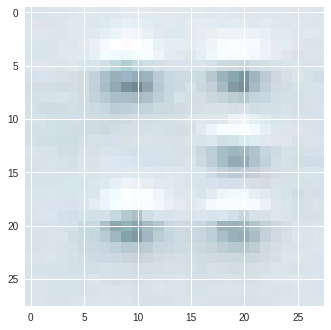

In [17]:
# Display 'y' in Brailles
import matplotlib.pyplot as plt
import numpy as np
dd = data[100][0].numpy()
print('Braille Target: Y/y')
plt.imshow(dd)
plt.show()


## CNN Model

### Define the Model

In [18]:
# import the nn.Module class
import torch.nn as nn

# defines the convolutional neural network
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.block1 = nn.Sequential(
            #3x28x28
            nn.Conv2d(in_channels=3, 
                      out_channels=16, 
                      kernel_size=5, 
                      stride=1, 
                      padding=2),
            #16x28x28
            nn.MaxPool2d(kernel_size=2)
            #16x14x14
        )
        #16x14x14
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=16, 
                      out_channels=32, 
                      kernel_size=5, 
                      stride=1, 
                      padding=2),
            #32x14x14
            nn.MaxPool2d(kernel_size=2)
            #32x7x7
        ) 
        # linearly 
        self.block3 = nn.Sequential(
            nn.Linear(32*7*7, 500),
            nn.Linear(500, 300),
            nn.Linear(300, 100),
            nn.Linear(100, 26)
        )
        
        #1x26
    
    def forward(self, x): 
        out = self.block1(x)
        out = self.block2(out)
        # flatten the dataset
        out = out.view(-1, 32*7*7)
        out = self.block3(out)
        
        return out

# convolutional neural network model
model = CNN()

# if using GPU
if use_gpu:
  # switch model to GPU
  model.cuda()

# print summary of the neural network model to check if everything is fine. 
print(model)
print("# parameter: ", sum([param.nelement() for param in model.parameters()]))
print(image.shape)

CNN(
  (block1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Linear(in_features=1568, out_features=500, bias=True)
    (1): Linear(in_features=500, out_features=300, bias=True)
    (2): Linear(in_features=300, out_features=100, bias=True)
    (3): Linear(in_features=100, out_features=26, bias=True)
  )
)
# parameter:  981574
torch.Size([28, 28, 3])


### Set the learning rate, criterion, & optimizer

In [0]:
#setting the learning rate
learning_rate = 1e-3

# Using a variable to store the cross entropy method
criterion = nn.CrossEntropyLoss()

# Using a variable to store the optimizer 
optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate)


### Train and Evaluate the data

In [30]:
t0 = time.time()

# variable to store the total loss
total_loss = []

# for loop that iterates over all the epochs
num_epochs = 10
for epoch in range(num_epochs):
    
    # variables to store/keep track of the loss and number of iterations
    train_loss = 0
    num_iter = 0
    
    # train the model
    model.train()
    
    # Iterate over data.
    for i, (images, labels) in enumerate(train_loader):  
      
       
        # print(images.shape)
        # print(labels)
        
        # need to permute so that the images are of size 3x28x28 
        # essential to be able to feed images into the model
        images = images.permute(0, 3, 1, 2)
        # print(images.shape)

        # if GPU is available 
        if use_gpu:
          # switch tensor type to GPU
          images = images.cuda()
          labels = labels.cuda()

        # Zero the gradient buffer
        # resets the gradient after each epoch so that the gradients don't add up
        optimizer.zero_grad()  
        
        # Forward
        outputs = model(images)
       
        # calculate the loss
        loss = criterion(outputs, labels.view(-1))
        print('loss:', loss)
        total_loss.append(loss)
        # Backward
        loss.backward()
        
        # Optimize
        # loops through all parameters and updates weights by using the gradients 
        optimizer.step()
        # update the training loss and number of iterations
        train_loss += loss.data[0]
        num_iter += 1
    
    print('Epoch: {}, Loss: {:.4f}'.format(
          epoch+1, train_loss/num_iter))
    
    # evaluate the model
    model.eval()

    correct = 0
    total = 0

    # Iterate over data.
    for images, labels in test_loader:  
       
       # need to permute so that the images are of size 3x28x28 
       # essential to be able to feed images into the model
       images = images.permute(0, 3, 1, 2)
      
       # if GPU is available 
       if use_gpu:
          # switch tensor type to GPU
          images = images.cuda()
          labels = labels.cuda()
          
       # Forward
       outputs = model(images)
       loss = criterion(outputs, labels.view(-1))
       _, predicted = torch.max(outputs.data, 1)
    
       # Statistics
       total += labels.size(0)
       correct += (predicted == labels).sum()
       
    print('Accuracy on the test set: {}%'.format(100 * correct / total))

tf = time.time()
print()
print("time: {} s" .format(tf-t0))

loss: tensor(3.3086)
loss: tensor(3.2081)
loss: tensor(3.3087)
loss: tensor(3.2799)
loss: tensor(3.2736)
loss: tensor(3.2189)
loss: tensor(3.1845)
loss: tensor(3.2326)
loss: tensor(3.2542)
loss: tensor(3.2586)
loss: tensor(3.1712)
loss: tensor(3.2626)
loss: tensor(3.2449)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


loss: tensor(3.2851)
loss: tensor(3.2101)
loss: tensor(3.2556)
loss: tensor(3.1874)
loss: tensor(3.2446)
loss: tensor(3.2638)
loss: tensor(3.2355)
loss: tensor(3.2758)
loss: tensor(3.2263)
loss: tensor(3.2432)
loss: tensor(3.2193)
loss: tensor(3.2580)
loss: tensor(3.2226)
loss: tensor(3.3182)
loss: tensor(3.2527)
loss: tensor(3.3379)
loss: tensor(3.2245)
loss: tensor(3.2753)
loss: tensor(3.2224)
loss: tensor(3.2677)
loss: tensor(3.1523)
loss: tensor(3.2356)
loss: tensor(3.2469)
loss: tensor(3.2639)
loss: tensor(3.2610)
loss: tensor(3.2490)
loss: tensor(3.2249)
loss: tensor(3.2152)
loss: tensor(3.2739)
loss: tensor(3.2166)
loss: tensor(3.2573)
loss: tensor(3.2536)
loss: tensor(3.2258)
loss: tensor(3.2732)
loss: tensor(3.2746)
loss: tensor(3.2534)
loss: tensor(3.3122)
loss: tensor(3.2301)
loss: tensor(3.2111)
loss: tensor(3.2470)
loss: tensor(3.2661)
loss: tensor(3.2415)
loss: tensor(3.2051)
loss: tensor(3.2035)
loss: tensor(3.2268)
loss: tensor(3.1981)
loss: tensor(3.2312)
loss: tensor(

loss: tensor(3.2698)
loss: tensor(3.2695)
loss: tensor(3.2695)
loss: tensor(3.2447)
loss: tensor(3.2901)
loss: tensor(3.2486)
loss: tensor(3.2373)
loss: tensor(3.2411)
loss: tensor(3.2136)
loss: tensor(3.2459)
loss: tensor(3.2582)
loss: tensor(3.2478)
loss: tensor(3.2824)
loss: tensor(3.3200)
loss: tensor(3.1967)
loss: tensor(3.2836)
loss: tensor(3.2624)
loss: tensor(3.2339)
loss: tensor(3.2588)
loss: tensor(3.1721)
loss: tensor(3.2361)
loss: tensor(3.3102)
loss: tensor(3.2612)
loss: tensor(3.2608)
loss: tensor(3.1825)
loss: tensor(3.2583)
loss: tensor(3.2818)
loss: tensor(3.2664)
loss: tensor(3.3078)
loss: tensor(3.2300)
loss: tensor(3.2730)
loss: tensor(3.2638)
loss: tensor(3.2661)
loss: tensor(3.2548)
loss: tensor(3.2730)
loss: tensor(3.2527)
loss: tensor(3.2365)
loss: tensor(3.1992)
loss: tensor(3.2054)
loss: tensor(3.1913)
loss: tensor(3.2684)
loss: tensor(3.1727)
loss: tensor(3.2552)
loss: tensor(3.2819)
loss: tensor(3.2545)
loss: tensor(3.2588)
loss: tensor(3.2157)
loss: tensor(

loss: tensor(3.2749)
loss: tensor(3.2473)
loss: tensor(3.2418)
loss: tensor(3.3104)
loss: tensor(3.1723)
loss: tensor(3.2391)
loss: tensor(3.3077)
loss: tensor(3.2575)
loss: tensor(3.2651)
loss: tensor(3.2159)
Epoch: 10, Loss: 3.2460
Accuracy on the test set: 19%

time: 11.473206758499146 s
